# Acceleration controller

Consider the system of a point body (vehicle) of mass $1$, moving without friction, and controlled by an external force.

The equations of the dynamics are given by

\begin{eqnarray*}
\left(\begin{array}{l}\ddot{x}\\ \ddot{y}\end{array}\right) & = & \gamma(t)
\end{eqnarray*}

$\gamma$ is assumed piecewise constant, with changing points at regular intervals (the control rate). At each changing points, the value of $\gamma$ is acquired from a controller, to which the current state of the system ($x,y,\dot{x},\dot{y}$) is communicated. The controller can thus keep a history of its observations, and base its decisions on it (control loop).

Documentation: [here](../doc/_build/html/odesimu.html)

In [1]:
%pylab notebook
# for external animation (less resource consuming), use appropriate backend, e.g. qt5

import logging
from functools import partial
from ipyshow.util import Setup
from ipyshow.odesimu import ControlledSystem
from ipyshow.odesimu.util import DPiecewiseFunc, buffered, blurred, logger_hook, PIDController, marker_hook

Populating the interactive namespace from numpy and matplotlib


## Vehicle class

In [2]:
#----------------------------------------------------------------------------------------------------
class Vehicle(ControlledSystem):
#----------------------------------------------------------------------------------------------------

  shadowshape = (2,)

  #integrator = dict(name='dopri5')
  # don't use the default intergrator lsoda, as it uses forward looking (not consistent with control)
  integrator = dict(name='dop853')

  def display(self,ax,bounds=None,**ka):
    ax.scatter((0,),(0,),c='k',marker='o')
    diag_s = ax.scatter((),(),c='b',marker='o',label='vehicle')
    tail_l, = ax.plot((),(),'y')
    ax.set_title(r'Vehicle under acceleration control')
    ax.set_xlim(bounds[0][0],bounds[1][0])
    ax.set_ylim(bounds[0][1],bounds[1][1])
    def disp(t,live,tail):
      diag_s.set_offsets((live,))
      tail_l.set_data(tail[:,0],tail[:,1])
    anim = super().display(ax,disp,**ka)
    ax.legend(fontsize='x-small') # must be last
    return anim

  @staticmethod
  @Setup(
    'x,y: position of vehicle [m]',
    'xʹ,yʹ: speed of vehicle [m.sec^-1]',
    x=0.,y=0.,xʹ=0.,yʹ=0.
  )
  def makestate(x,y,xʹ,yʹ): return array((x,y,xʹ,yʹ))

  @Setup(
    ControlledSystem.launch,
    'bounds: corners of display',
    'crate: control rate',
    taild=10.,hooks=(partial(logger_hook,logger=logging.getLogger()),)
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)


In [3]:
Setup.display(Vehicle,PIDController)

**** Vehicle.launch(self, *a, **ka) ****
    ini       : initial state []
    srate     (25.0      ): sampling rate [sec^-1]
    maxtime   (inf       ): total simulation time length [sec]
    taild     (10.0      ): shadow duration [sec]
    hooks     ((functools): tuple of display hooks []
    bounds    : corners of display []
    crate     : control rate []
**** Vehicle.makestate(x, y, xʹ, yʹ) ****
    x,y       (0.0,0.0   ): position of vehicle [m]
    xʹ,yʹ     (0.0,0.0   ): speed of vehicle [m.sec^-1]
**** PIDController.__init__(self, gP, gI, gD, observe, action, **ka) ****
    N         : size of the buffer of change points []
    gP        (None      ): proportional control gain as error quantity per observation quantity [err]
    gI        (None      ): integral control gain [err.sec^-1]
    gD        (None      ): derivative control gain [err.sec]
    observe   (None      ): input to observation transform []
    action    (None      ): error to output transform []

<IPython.core.display.Javascript object>


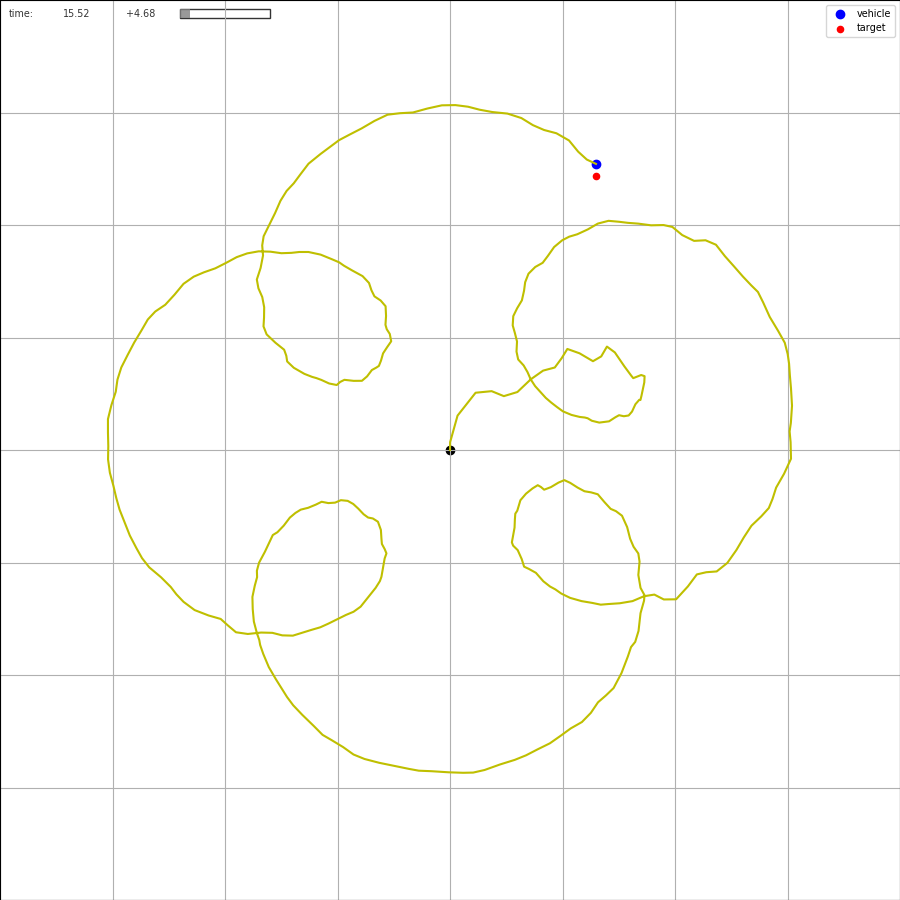

In [6]:
logging.basicConfig(level='WARN') # can be changed dynamically by logger_hook

period = 15
def target_still(t,spot=array((7.,5.))): return spot
def target_circle(t,R=4.,ω=2*pi/period):
  θ = ω*t
  return R*hstack((sin(θ),cos(θ)))
def target_cycloid(t,R=4.,r=2.,l=-5.,ω=2*pi/period):
  θ = ω*t
  return R*hstack((sin(θ),cos(θ)))+r*hstack((sin(l*θ),cos(l*θ)))

#target = target_still
#target = buffered(T=period,N=int(period*100))(target_circle)
target = buffered(T=period,N=int(period*100))(partial(target_cycloid,l=5.))

blur = .05
#blur = None

control = PIDController(
  N=2,gP=30.,gI=8.,gD=30.,
  observe=blurred(blur,offset=(.7,.5))(lambda x: x[1][:2]-target(x[0])), # x = current-time,current-state
  action=None
)

syst = Vehicle(control)
syst.launch(
  ini=syst.makestate(x=0.,y=0.,xʹ=0.,yʹ=0.),
  crate=30.,
  bounds=((-8.,-8.),(8.,8.)),
  hooks=(partial(marker_hook,f=target,marker='o',s=20,label='target'),partial(logger_hook,logger=logging.getLogger())),
  taild=period+5.,
)